## CIFAR-10: Logistic Regression (2-classes)
CIFAR10 (two classes) with logistic regression trained bith random permutation cyclic batch SGD

In [1]:
import torch
import torch.nn as nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms

import matplotlib.pyplot as plt

In [13]:
'''
Step 1: Prepare dataset
'''
# Use only 2 labels
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
label_1 = classes.index('plane')
label_2 = classes.index('car')

# dataset class for our custom data
class CIFAR10_2class(datasets.CIFAR10) :
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super().__init__(root, train=train, transform=transform,
                                                 target_transform=target_transform, download=download)
        
        self.data = torch.tensor(self.data)
        self.targets = torch.tensor(self.targets)
        
        idx = (self.targets == label_1) + (self.targets == label_2)
        self.data = self.data[idx]
        self.targets = self.targets[idx].view(-1, 1)
        self.targets[self.targets == label_1] = -1
        self.targets[self.targets == label_2] = 1

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

    def __len__(self):
        return len(self.data)   
        
        
# CIFAR-10 training data
train_set = CIFAR10_2class(root='./cifar_data/', train=True, transform=transforms.ToTensor(), download=True)

# CIFAR-10 testing data
test_set = CIFAR10_2class(root='./cifar_data/', train=False, transform=transforms.ToTensor())

Files already downloaded and verified


In [3]:
'''
Step 2: Define the neural network class.
'''
class LR(nn.Module) :
    '''
    Initialize model
        input_dim : dimension of given input data
    '''
    # CIFAR-10 data is 32*32 images with 3 RGB channels
    def __init__(self, input_dim=3*32*32) :
        super().__init__()
        self.linear = nn.Linear(input_dim, 1, bias=False)
        # The network parameters are part of the neural network object.
        # therefore they are initialized as class attributes in the __init__ method
        
    ''' forward given input x '''
    def forward(self, x) :
        # The forward network defines how the neurons are combined to form the network.
        # How the connections are formed, and what activation functions are used are defined here.
        # The definition here should not introduce new parameters.
        x = self.linear(x.float().view(-1, 3*32*32))    # Flattens the given data(tensor)
        return x
    

[Test set] Average loss: 2181.0872, Accuracy: 1323/2000 (66.15%)



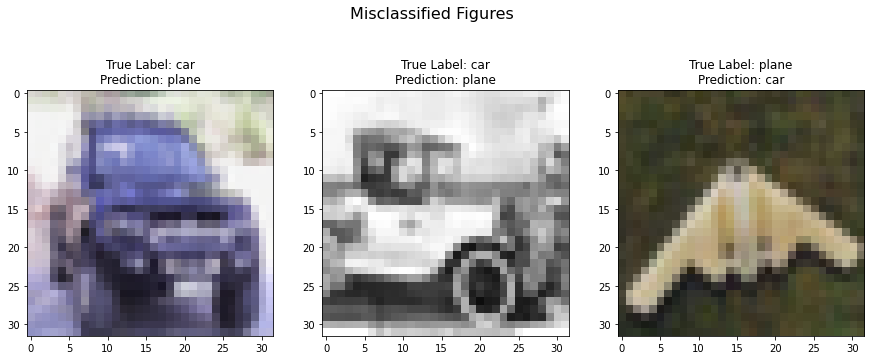

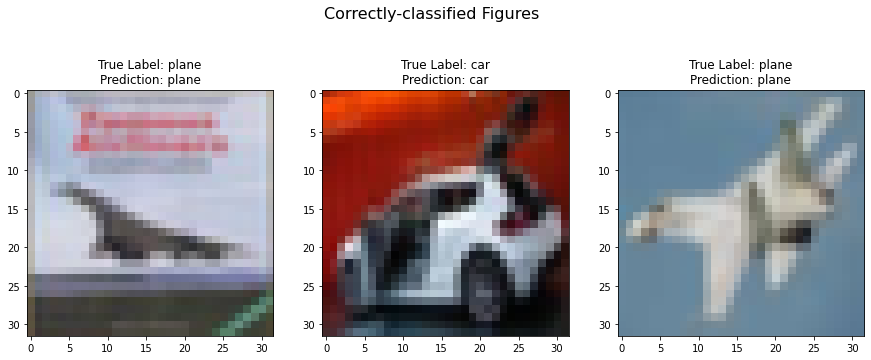

In [14]:
'''
Step 3: Create the model, specify loss function and optimizer.
'''
model = LR()  # Define Neural Network Models 

def logistic_loss(output, target):
    return torch.mean(-torch.nn.functional.logsigmoid(target.reshape(-1)*output.reshape(-1)))
loss_function = logistic_loss                            # Specify loss function

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)  # specify SGD with learning rate



'''
Step 4: Train model with SGD
'''
# Use DataLoader class
train_loader = DataLoader(dataset=train_set, batch_size=1024, shuffle=True)

# Train the model
for epoch in range(10) :
    for images, labels in train_loader :

        # Clear previously computed gradient
        optimizer.zero_grad()
        # then compute gradient with forward and backward passes
        train_loss = loss_function(model(images), labels.float())
        train_loss.backward()

        # perform SGD step (parameter update)
        optimizer.step()
    

'''
Step 5: Test model (Evaluate the accuracy)
'''
test_loss, correct = 0, 0
misclassified_ind = []
correct_ind = []

# Test data
test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=False)

# Evaluate accuracy using test data
for ind, (image, label) in enumerate(test_loader) :

    # Forward pass
    output = model(image)
    
    # Calculate cumulative loss
    test_loss += loss_function(output, label.float()).item()

    # Make a prediction
    if output.item() * label.item() >= 0 :
        correct += 1
        correct_ind += [ind]
    else:
        misclassified_ind += [ind]

# Print out the results
print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss /len(test_loader), correct, len(test_loader),
        100. * correct / len(test_loader)))



'''
Step 6: Show some incorrectly classified images and some correctly classified ones
''' 
# Misclassified images
fig = plt.figure(1, figsize=(15, 6))
fig.suptitle('Misclassified Figures', fontsize=16)

for k in range(3) :
    image = test_set.data[misclassified_ind[k]].cpu().numpy().astype('uint8')
    ax = fig.add_subplot(1, 3, k+1)
    true_label = test_set.targets[misclassified_ind[k]]
    
    if true_label == -1 :
        ax.set_title('True Label: {}\nPrediction: {}'.format(classes[label_1], classes[label_2]))
    else :
        ax.set_title('True Label: {}\nPrediction: {}'.format(classes[label_2], classes[label_1]))
    plt.imshow(image)
plt.show()

# Correctly classified images
fig = plt.figure(2, figsize=(15, 6))
fig.suptitle('Correctly-classified Figures', fontsize=16)

for k in range(3) :
    image = test_set.data[correct_ind[k]].cpu().numpy().astype('uint8')
    ax = fig.add_subplot(1, 3, k+1)
    true_label = test_set.targets[correct_ind[k]]

    if true_label == -1 :
        ax.set_title('True Label: {}\nPrediction: {}'.format(classes[label_1], classes[label_1]))
    else :
        ax.set_title('True Label: {}\nPrediction: {}'.format(classes[label_2], classes[label_2]))
    plt.imshow(image)
plt.show()

## CIFAR-10:  Multilayer perceptron (MLP4), still 2-classes

[Test set] Average loss: 0.4042, Accuracy: 1625/2000 (81.25%)



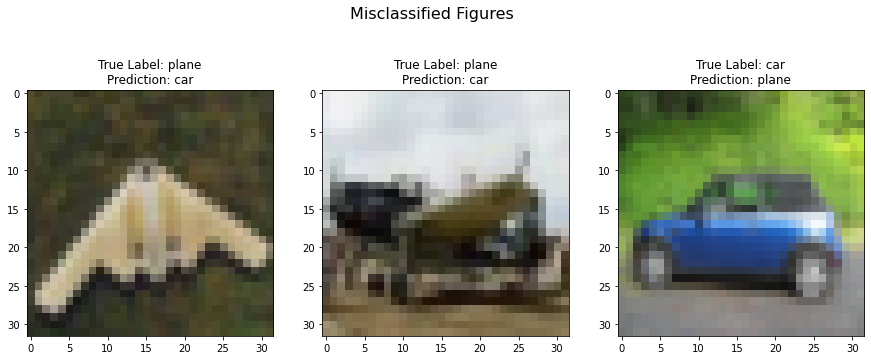

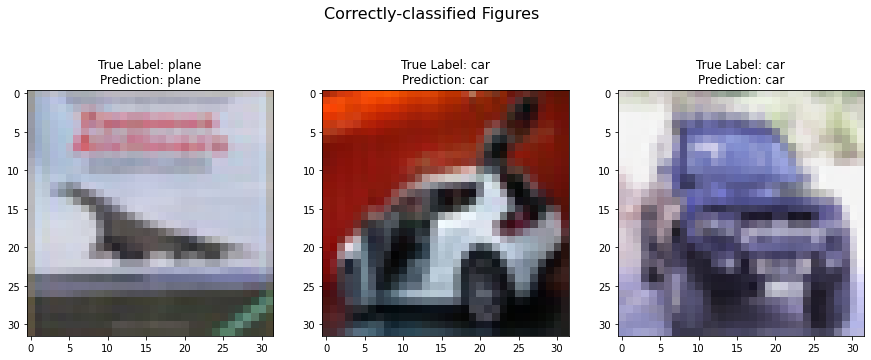

In [15]:
'''
Step 2: Define the neural network class (LOOK HERE)
'''
class MLP4(nn.Module) :
    '''
    Initialize model
        input_dim : dimension of given input data
    '''
    # CIFAR-10 data is 32*32 images with 3 RGB channels
    def __init__(self, input_dim=3*32*32) :
        super().__init__()
        self.linear = nn.Linear(input_dim, input_dim//2, bias=True)  # 3072 input -> 1536  (3//2 = 1)
        self.linear2 = nn.Linear(input_dim//2, input_dim//4, bias=True)
        self.linear3 = nn.Linear(input_dim//4, input_dim//8, bias=True)
        self.linear4 = nn.Linear(input_dim//8, 1, bias=True)
        
    ''' forward given input x '''
    def forward(self, x) :
        x = x.float().view(-1, 3*32*32)
        x = nn.functional.relu(self.linear(x))
        x = nn.functional.relu(self.linear2(x))
        x = nn.functional.relu(self.linear3(x))
        x = self.linear4(x)
        return x
    
    
'''
Step 3: Create the model, specify loss function and optimizer (LOOK HERE)
'''
model = MLP4()  # Define Neural Network Models 

def logistic_loss(output, target):
    return torch.mean(-torch.nn.functional.logsigmoid(target.reshape(-1)*output.reshape(-1)))
loss_function = logistic_loss                            # Specify loss function

optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)  # specify SGD with learning rate



'''
Step 4: (same step)
'''
# Use DataLoader class
train_loader = DataLoader(dataset=train_set, batch_size=1024, shuffle=True)

# Train the model

for epoch in range(10) :
    for images, labels in train_loader :

        # Clear previously computed gradient
        optimizer.zero_grad()
        # then compute gradient with forward and backward passes
        train_loss = loss_function(model(images), labels.float())
        train_loss.backward()

        # perform SGD step (parameter update)
        optimizer.step()
    

'''
Step 5: (same step)
'''
test_loss, correct = 0, 0
misclassified_ind = []
correct_ind = []

# Test data
test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=False)

# Evaluate accuracy using test data
for ind, (image, label) in enumerate(test_loader) :

    # Forward pass
    output = model(image)
    
    # Calculate cumulative loss
    test_loss += loss_function(output, label.float()).item()

    # Make a prediction
    if output.item() * label.item() >= 0 :
        correct += 1
        correct_ind += [ind]
    else:
        misclassified_ind += [ind]

# Print out the results
print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss /len(test_loader), correct, len(test_loader),
        100. * correct / len(test_loader)))



'''
Step 6: (same step)
''' 
# Misclassified images
fig = plt.figure(1, figsize=(15, 6))
fig.suptitle('Misclassified Figures', fontsize=16)

for k in range(3) :
    image = test_set.data[misclassified_ind[k]].cpu().numpy().astype('uint8')
    ax = fig.add_subplot(1, 3, k+1)
    true_label = test_set.targets[misclassified_ind[k]]
    
    if true_label == -1 :
        ax.set_title('True Label: {}\nPrediction: {}'.format(classes[label_1], classes[label_2]))
    else :
        ax.set_title('True Label: {}\nPrediction: {}'.format(classes[label_2], classes[label_1]))
    plt.imshow(image)
plt.show()

# Correctly classified images
fig = plt.figure(2, figsize=(15, 6))
fig.suptitle('Correctly-classified Figures', fontsize=16)

for k in range(3) :
    image = test_set.data[correct_ind[k]].cpu().numpy().astype('uint8')
    ax = fig.add_subplot(1, 3, k+1)
    true_label = test_set.targets[correct_ind[k]]

    if true_label == -1 :
        ax.set_title('True Label: {}\nPrediction: {}'.format(classes[label_1], classes[label_1]))
    else :
        ax.set_title('True Label: {}\nPrediction: {}'.format(classes[label_2], classes[label_2]))
    plt.imshow(image)
plt.show()

### Examine total parameter count of MLP4

In [6]:
class LR(nn.Module) :
    '''
    Initialize model
        input_dim : dimension of given input data
    '''
    # CIFAR-10 data is 32*32 images with 3 RGB channels
    def __init__(self, input_dim=3*32*32) :
        super().__init__()
        self.linear = nn.Linear(input_dim, 1, bias=True)
        # The network parameters are part of the neural network object.
        # therefore they are initialized as class attributes in the __init__ method
        
    ''' forward given input x '''
    def forward(self, x) :
        # The forward network defines how the neurons are combined to form the network.
        # How the connections are formed, and what activation functions are used are defined here.
        # The definition here should not introduce new parameters.
        x = self.linear(x.float().view(-1, 3*32*32))    # Flattens the given data(tensor)
        return x
    


class MLP4(nn.Module) :
    '''
    Initialize model
        input_dim : dimension of given input data
    '''
    # CIFAR-10 data is 32*32 images with 3 RGB channels
    def __init__(self, input_dim=3*32*32) :
        super().__init__()
        self.linear = nn.Linear(input_dim, input_dim//2, bias=True)
        self.linear2 = nn.Linear(input_dim//2, input_dim//4, bias=True)
        self.linear3 = nn.Linear(input_dim//4, input_dim//8, bias=True)
        self.linear4 = nn.Linear(input_dim//8, 1, bias=True)
        
    ''' forward given input x '''
    def forward(self, x) :
        x = x.float().view(-1, 3*32*32)
        x = nn.functional.relu(self.linear(x))
        x = nn.functional.relu(self.linear2(x))
        x = nn.functional.relu(self.linear3(x))
        x = self.linear4(x)
        return x
    
    

model1 = LR()
model2 = MLP4()

print("LR model parameters")
param_num = 0
for parameter in model1.parameters():
    print(parameter.shape)
    param_num += parameter.numel()
print("LR has a total of {} parameters.".format(param_num))
print("--------------------------------------------------------------------------------")

print("MLP4 model parameters")    
param_num = 0
for parameter in model2.parameters():
    print(parameter.shape)
    param_num += parameter.numel()
print("MLP4 has a total of {} parameters.".format(param_num))

LR model parameters
torch.Size([1, 3072])
torch.Size([1])
LR has a total of 3073 parameters.
--------------------------------------------------------------------------------
MLP4 model parameters
torch.Size([1536, 3072])
torch.Size([1536])
torch.Size([768, 1536])
torch.Size([768])
torch.Size([384, 768])
torch.Size([384])
torch.Size([1, 384])
torch.Size([1])
MLP4 has a total of 6196225 parameters.


## MNIST: Softmax (10-classes)

In [16]:
'''
Step 1: Load the entire MNIST dataset
'''
class MNIST_class(datasets.MNIST) :
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super().__init__(root, train=train, transform=transform,
                                                 target_transform=target_transform, download=download)
        
        # Move data to GPU
        device = torch.device("cpu")
        self.data = self.data.to(device)
        self.targets = self.targets.to(device)
            
    def __getitem__(self, index):
        return self.data[index], self.targets[index]

    def __len__(self):
        return len(self.data)


# MNIST training data
train_MNIST = MNIST_class(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)

test_MNIST = MNIST_class(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)


'''
Step 2: Since there are 10 classes, the output should be 10
'''
class softmax(nn.Module) :
    '''
    Initialize model
        input_dim : dimension of given input data
    '''
    # MNIST data is 28x28 images
    def __init__(self, input_dim=28*28) :
        super().__init__()
        self.linear = nn.Linear(input_dim, 10, bias=True)

    ''' forward given input x '''
    def forward(self, x) :
        return self.linear(x.float().view(-1, 28*28))

'''
Step 3: Create the model, specify loss function and optimizer
'''
model = softmax().to("cpu")                         # Define a Neural Network Model

loss_function = torch.nn.CrossEntropyLoss()     # Specify loss function
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)   # specify SGD with learning rate



'''
Step 4: Train model with SGD
'''
train_loader = DataLoader(dataset=train_MNIST, batch_size=64, shuffle=True)

import time
start = time.time()
for epoch in range(1) :
    for images, labels in train_loader :
        # Clear previously computed gradient
        optimizer.zero_grad()

        # then compute gradient with forward and backward passes
        train_loss = loss_function(model(images), labels)
        train_loss.backward()

        # perform SGD step (parameter update)
        optimizer.step()
end = time.time()
print("Time ellapsed in training is: {}".format(end - start))


'''
Step 5: (same step)
'''
test_loss, correct = 0, 0

# Test data
test_loader = DataLoader(dataset=test_MNIST, batch_size=1, shuffle=False)
# no need to shuffle test data

# Evaluate accuracy using test data
for ind, (image, label) in enumerate(test_loader) :

    # Forward pass
    output = model(image)

    # Calculate cumulative loss
    test_loss += loss_function(output, label).item()

    # Get index of maximum log-probability
    pred = output.max(1, keepdim=True)[1]

    # Trace correct predictions
    correct += pred.eq(label.view_as(pred)).sum().item()

            
# Print out the results
print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss /len(test_loader), correct, len(test_loader),
        100. * correct / len(test_loader)))

Time ellapsed in training is: 0.9444999694824219
[Test set] Average loss: 37.9045, Accuracy: 7494/10000 (74.94%)



In [9]:
print("Softmax model parameters")
param_num = 0
for parameter in model.parameters():
    print(parameter.shape)
    param_num += parameter.numel()
print("Softmax has a total of {} parameters.".format(param_num))

Softmax model parameters
torch.Size([10, 784])
torch.Size([10])
Softmax has a total of 7850 parameters.


## MNIST: Multilayer Perceptron with Softmax(10-classes)

In [17]:
# model
class MLP4_softmax(nn.Module) :
    '''
    Initialize model
        input_dim : dimension of given input data
    '''
    # MNIST data is 28*28
    def __init__(self, input_dim=28*28) :
        super().__init__()
        self.linear = nn.Linear(input_dim, input_dim//2, bias=True)
        self.linear2 = nn.Linear(input_dim//2, input_dim//4, bias=True)
        self.linear3 = nn.Linear(input_dim//4, input_dim//8, bias=True)
        self.linear4 = nn.Linear(input_dim//8, 10, bias=True)
        
    ''' forward given input x '''
    def forward(self, x) :
        x = x.float().view(-1, 28*28)
        x = nn.functional.relu(self.linear(x))
        x = nn.functional.relu(self.linear2(x))
        x = nn.functional.relu(self.linear3(x))
        x = self.linear4(x)
        return x

model = MLP4_softmax()                       # Define a Neural Network Model

loss_function = torch.nn.CrossEntropyLoss()     # Specify loss function
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)   # specify SGD with learning rate

# train
train_loader = DataLoader(dataset=train_MNIST, batch_size=64, shuffle=True)

import time
start = time.time()
for epoch in range(1) :
    for images, labels in train_loader :
        # Clear previously computed gradient
        optimizer.zero_grad()

        # then compute gradient with forward and backward passes
        train_loss = loss_function(model(images), labels)
        train_loss.backward()

        # perform SGD step (parameter update)
        optimizer.step()
end = time.time()
print("Time ellapsed in training is: {}".format(end - start))


# test
test_loss, correct = 0, 0

# Test data
test_loader = DataLoader(dataset=test_MNIST, batch_size=1, shuffle=False)
# no need to shuffle test data

# Evaluate accuracy using test data
for ind, (image, label) in enumerate(test_loader) :

    # Forward pass
    output = model(image)

    # Calculate cumulative loss
    test_loss += loss_function(output, label).item()

    # Get index of maximum log-probability
    pred = output.max(1, keepdim=True)[1]

    # Trace correct predictions
    correct += pred.eq(label.view_as(pred)).sum().item()

            
# Print out the results
print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss /len(test_loader), correct, len(test_loader),
        100. * correct / len(test_loader)))

Time ellapsed in training is: 3.8714990615844727
[Test set] Average loss: 0.2174, Accuracy: 9341/10000 (93.41%)



## CIFAR-10: Softmax (10-classes)

In [18]:

'''
Step 1: Load the entire CIFAR-10 dataset
'''

train_CIFAR = datasets.CIFAR10(root='./cifar_10data/',
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_CIFAR = datasets.CIFAR10(root='./cifar_10data/',
                              train=False, 
                              transform=transforms.ToTensor())

'''
Step 2: Since there are 10 classes, the output should be 10
'''
class softmax(nn.Module) :
    '''
    Initialize model
        input_dim : dimension of given input data
    '''
    def __init__(self, input_dim=3*32*32) :
        super().__init__()
        self.linear = nn.Linear(input_dim, 10, bias=True)

    ''' forward given input x '''
    def forward(self, x) :
        return self.linear(x.float().view(-1, 3*32*32))

'''
Step 3: Create the model, specify loss function and optimizer
'''
model = softmax().to("cpu")                         # Define a Neural Network Model

loss_function = torch.nn.CrossEntropyLoss()     # Specify loss function
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)   # specify SGD with learning rate



'''
Step 4: Train model with SGD
'''
train_loader = DataLoader(dataset=train_CIFAR, batch_size=64, shuffle=True)

import time
start = time.time()
for epoch in range(1) :
    for images, labels in train_loader :
        # Clear previously computed gradient
        optimizer.zero_grad()

        # then compute gradient with forward and backward passes
        train_loss = loss_function(model(images), labels)
        train_loss.backward()

        # perform SGD step (parameter update)
        optimizer.step()
end = time.time()
print("Time ellapsed in training is: {}".format(end - start))


'''
Step 5: (same step)
'''
test_loss, correct = 0, 0

# Test data
test_loader = DataLoader(dataset=test_CIFAR, batch_size=1, shuffle=False)
# no need to shuffle test data

# Evaluate accuracy using test data
for ind, (image, label) in enumerate(test_loader) :

    # Forward pass
    output = model(image)

    # Calculate cumulative loss
    test_loss += loss_function(output, label).item()

    # Get index of maximum log-probability
    pred = output.max(1, keepdim=True)[1]

    # Trace correct predictions
    correct += pred.eq(label.view_as(pred)).sum().item()

            
# Print out the results
print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss /len(test_loader), correct, len(test_loader),
        100. * correct / len(test_loader)))

Files already downloaded and verified
Time ellapsed in training is: 4.632500171661377
[Test set] Average loss: 2.0420, Accuracy: 2956/10000 (29.56%)



## CIFAR-10: MLP4 with Softmax (10-classes)
Which learning rate would you choose?

In [19]:
# model
class MLP4(nn.Module) :
    '''
    Initialize model
        input_dim : dimension of given input data
    '''
    # CIFAR-10 data is 32*32 images with 3 RGB channels
    def __init__(self, input_dim=3*32*32) :
        super().__init__()
        self.linear = nn.Linear(input_dim, input_dim//2, bias=True)
        self.linear2 = nn.Linear(input_dim//2, input_dim//4, bias=True)
        self.linear3 = nn.Linear(input_dim//4, input_dim//8, bias=True)
        self.linear4 = nn.Linear(input_dim//8, 10, bias=True)
        
    ''' forward given input x '''
    def forward(self, x) :
        x = x.float().view(-1, 3*32*32)
        x = nn.functional.relu(self.linear(x))
        x = nn.functional.relu(self.linear2(x))
        x = nn.functional.relu(self.linear3(x))
        x = self.linear4(x)
        return x

model = MLP4()                       # Define a Neural Network Model

loss_function = torch.nn.CrossEntropyLoss()     # Specify loss function
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)   # specify SGD with learning rate

# train
train_loader = DataLoader(dataset=train_CIFAR, batch_size=64, shuffle=True)

import time
start = time.time()
for epoch in range(1) :
    for images, labels in train_loader :
        # Clear previously computed gradient
        optimizer.zero_grad()

        # then compute gradient with forward and backward passes
        train_loss = loss_function(model(images), labels)
        train_loss.backward()

        # perform SGD step (parameter update)
        optimizer.step()
end = time.time()
print("Time ellapsed in training is: {}".format(end - start))


# test
test_loss, correct = 0, 0

# Test data
test_loader = DataLoader(dataset=test_CIFAR, batch_size=1, shuffle=False)
# no need to shuffle test data

# Evaluate accuracy using test data
for ind, (image, label) in enumerate(test_loader) :

    # Forward pass
    output = model(image)

    # Calculate cumulative loss
    test_loss += loss_function(output, label).item()

    # Get index of maximum log-probability
    pred = output.max(1, keepdim=True)[1]

    # Trace correct predictions
    correct += pred.eq(label.view_as(pred)).sum().item()

            
# Print out the results
print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss /len(test_loader), correct, len(test_loader),
        100. * correct / len(test_loader)))

Time ellapsed in training is: 33.77500247955322
[Test set] Average loss: 2.0688, Accuracy: 2578/10000 (25.78%)



### Takeaway
- Learning rate 1e-2 (or 1e-3) was not enough
- Need more epoch
- Need GPU!!!